In [3]:
# Graph Neural Networks detection & localization, using only voltage mag & ang
from utils import *

def load_day_data(pkl):
    with open(pkl, 'rb') as f:
        data = pickle.load(f)

    v_sch, t_sch = data['sch_v'], data['sch_θ']
    v_att, t_att = data['attack_v'], data['attack_θ']

    steps = [f"x{i}" for i in range(ATTACK_WINDOW[0], ATTACK_WINDOW[1] + 1) if f"x{i}" in v_sch]

    V_sch = np.array([v_sch[s] for s in steps]).T
    T_sch = np.array([t_sch[s] for s in steps]).T
    V_att = np.array([v_att.get(s, v_sch[s]) for s in steps]).T
    T_att = np.array([t_att.get(s, t_sch[s]) for s in steps]).T

    # features: diff + stats
    dV, dT = V_att - V_sch, T_att - T_sch
    X = np.concatenate([
        dV, dT,
        V_sch.mean(axis=1, keepdims=True), V_sch.std(axis=1, keepdims=True),
        T_sch.mean(axis=1, keepdims=True), T_sch.std(axis=1, keepdims=True),
        np.abs(dV).max(axis=1, keepdims=True), np.abs(dT).max(axis=1, keepdims=True)
    ], axis=1)

    # node labels: normal or attacked
    y = np.zeros(N_NODES, dtype=np.float32)
    for node in ATTACKED_NODES:
        if node < N_NODES:
            y[node] = 1.0

    return X, y

print(f"FDIA detection | only voltage available\n")
adj = load_adj_matrix('topology.csv')
print(f"Grid topology: {N_NODES}-bus, {int(np.sum(adj)) // 2}-edge\n")  # edges includes transformers & switches
X, y, d = load_all_days(DATA, load_day_data)
print(f"total data: {X.shape}, attack ratio={y.mean():.3f}\n")

FDIA detection | only voltage available

Grid topology: 187-bus, 188-edge



Loading v3: 100%|██████████| 200/200 [00:01<00:00, 151.12it/s]

total data: (809, 187, 98), attack ratio=0.016



In [4]:
# normalize & split
X = (X - X.mean((0, 1), keepdims=True)) / (X.std((0, 1), keepdims=True) + 1e-8)
split = int(len(X) * 0.75) ## 3 seasons as train, 1 as test, adjust as needed
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# balance class weights (mitigate 3:184 imbalance), adjust ratio according to attack intensity
weight = (y_train.size - y_train.sum()) / (y_train.sum() + 1e-8) * 0.5
print(f"{X_train.shape[0]} training + {X_test.shape[0]} test days | positive class weight={weight:.1f}\n")

# build & train
model = gcn(N_NODES, X.shape[2], adj)
model.compile(
    optimizer=keras.optimizers.Adam(3e-3), loss=WeightedBCE(pos_weight=weight),
    metrics=[
        keras.metrics.BinaryAccuracy(name='acc', threshold=0.5),
        keras.metrics.Precision(name='prec', thresholds=0.5),
        keras.metrics.Recall(name='rec', thresholds=0.5),
        keras.metrics.AUC(name='auc')
    ]
)

hist = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=400, batch_size=32, verbose=1,
    callbacks=[ # early stopping upon perfect AUC
        keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, mode='max'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-6, mode='max')
    ]
)

# eval
y_pred = model.predict(X_test, verbose=0)[:, :, 0]

606 training + 203 test days | positive class weight=30.7

Epoch 1/400
19/19 [==============================] - 1s 21ms/step - loss: 0.6736 - acc: 0.7781 - prec: 0.0652 - rec: 0.9615 - auc: 0.9288 - val_loss: 0.8170 - val_acc: 0.9840 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.7695 - lr: 0.0030
Epoch 2/400
19/19 [==============================] - 0s 9ms/step - loss: 0.3159 - acc: 0.9150 - prec: 0.1560 - rec: 0.9741 - auc: 0.9695 - val_loss: 0.7893 - val_acc: 0.9840 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.8103 - lr: 0.0030
Epoch 3/400
19/19 [==============================] - 0s 8ms/step - loss: 0.2677 - acc: 0.9253 - prec: 0.1727 - rec: 0.9648 - auc: 0.9734 - val_loss: 0.7695 - val_acc: 0.9840 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.8471 - lr: 0.0030
Epoch 4/400
19/19 [==============================] - 0s 8ms/step - loss: 0.2458 - acc: 0.9279 - prec: 0.1790 - rec: 0.9736 - auc: 0.9757 - val_loss: 0.7525 - val_acc: 0.9840 - val_prec: 0.00


Top 10 suspicious nodes (avg score across 203 test days):
 33: 0.996 [ATTACK]
 163: 0.996 [ATTACK]
 34: 0.986 [ATTACK]
 31: 0.380 
 32: 0.271 
 29: 0.225 
 112: 0.122 
 135: 0.112 
 30: 0.091 
 186: 0.086 

Classification Report
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     37352
      attack       0.99      0.99      0.99       609

    accuracy                           1.00     37961
   macro avg       1.00      1.00      1.00     37961
weighted avg       1.00      1.00      1.00     37961



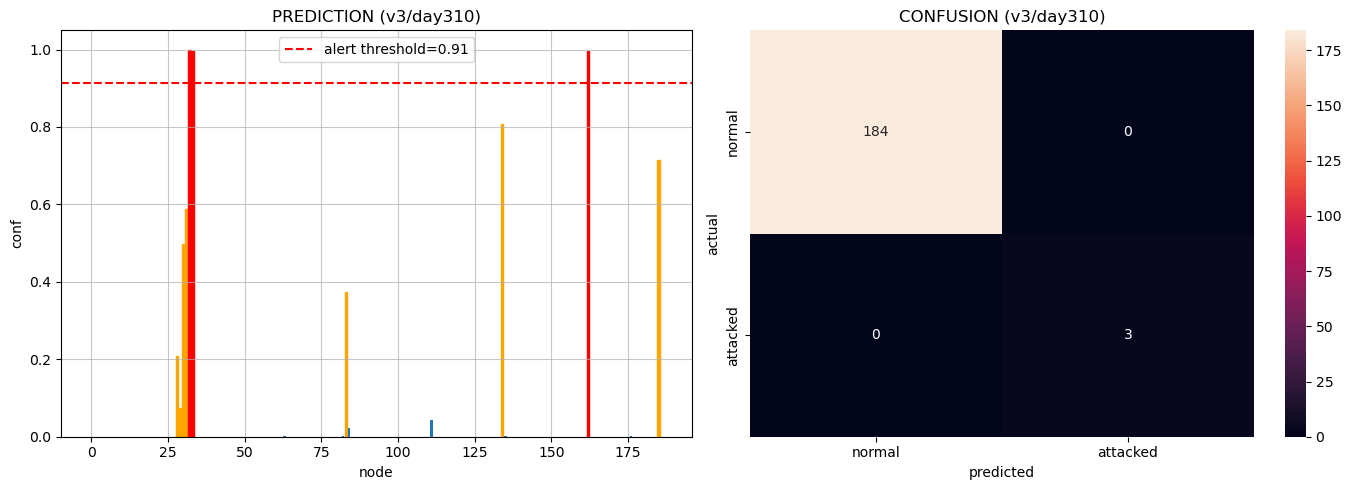

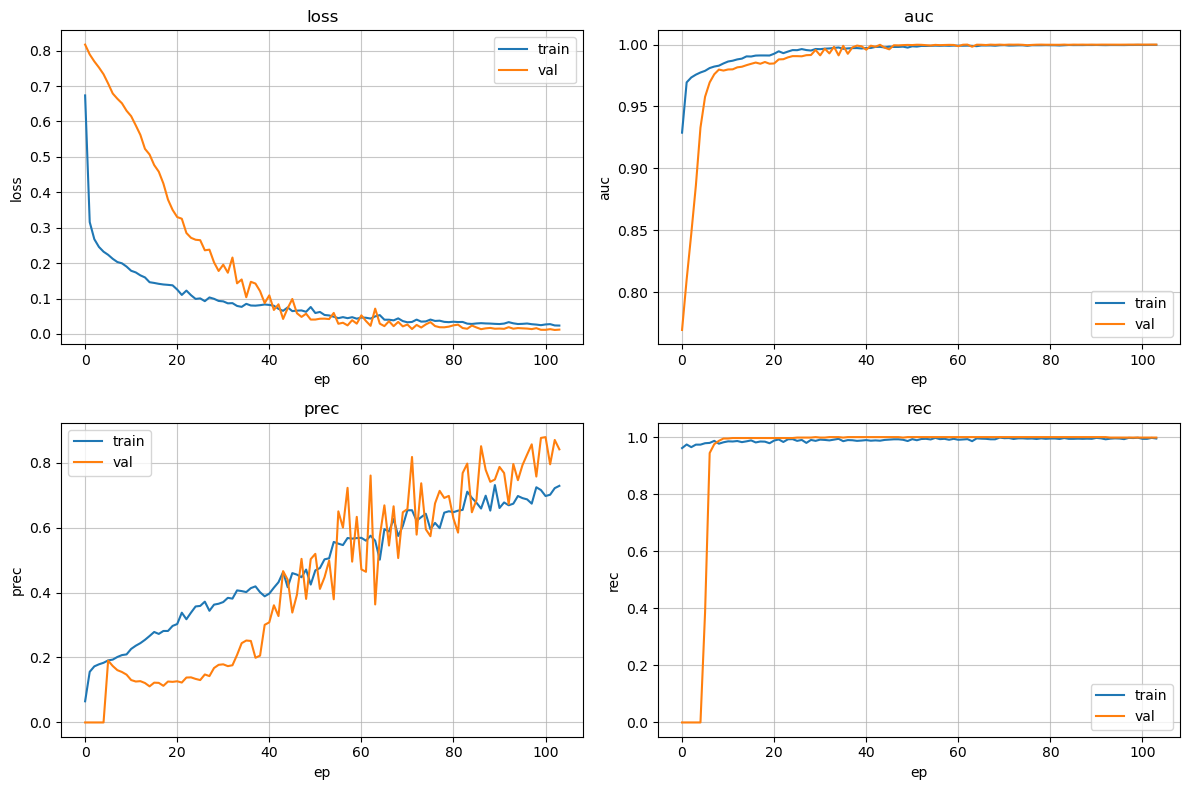

In [5]:
thresh = np.linspace(0.5, 1.0, 100)    # find optimal threshold via maximizing f1 score
f1 = []
for t in thresh:
    y_bin = (y_pred > t).astype(int)
    tp = ((y_bin == 1) & (y_test == 1)).sum()
    fp = ((y_bin == 1) & (y_test == 0)).sum()
    fn = ((y_bin == 0) & (y_test == 1)).sum()
    p = tp / (tp + fp + 1e-8)
    r = tp / (tp + fn + 1e-8)
    f1.append(2 * p * r / (p + r + 1e-8))

thresh_opt = thresh[np.argmax(f1)]
y_pred_bin = (y_pred > thresh_opt).astype(int)

print(f"\nTop 10 suspicious nodes (avg score across {X_test.shape[0]} test days):")
node_scores = y_pred.mean(axis=0)
for n in np.argsort(node_scores)[-10:][::-1]:
    print(f" {n + 1}: {node_scores[n]:.3f} {'[ATTACK]' if n in ATTACKED_NODES else ''}")
print("\nClassification Report")
print(classification_report(y_test.flatten(), y_pred_bin.flatten(), target_names=['normal', 'attack']))

# visualization
idx = 101   # range from 0 to 202 under 3:1 trn/tst
day = d[split:][idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bars = axes[0].bar(range(N_NODES), y_pred[idx])
axes[0].axhline(thresh_opt, c='r', ls='--', label=f'alert threshold={thresh_opt:.2f}')
for i in np.argsort(y_pred[idx])[-10:]:
    bars[i].set_color('red' if i in ATTACKED_NODES else 'orange')
axes[0].set(xlabel='node', ylabel='conf', title=f'PREDICTION ({day})')
axes[0].legend()
axes[0].grid(alpha=0.7)

sns.heatmap(confusion_matrix(y_test[idx], y_pred_bin[idx]), fmt='d', annot=True, ax=axes[1])
axes[1].set(xlabel='predicted', ylabel='actual', title=f'CONFUSION ({day})')
axes[1].set_xticklabels(['normal', 'attacked'])
axes[1].set_yticklabels(['normal', 'attacked'])

plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, k in enumerate(['loss', 'auc', 'prec', 'rec']):
    ax = axes[i // 2, i % 2]
    ax.plot(hist.history[k], label='train')
    ax.plot(hist.history[f'val_{k}'], label='val')
    ax.set(xlabel='ep', ylabel=k, title=k)
    ax.legend()
    ax.grid(alpha=0.7)

plt.tight_layout()